## **Problem Statement**

The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms.

One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention.

Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance.

While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms.

Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

## **Install Some Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
#import utils
import os
%matplotlib inline

tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.layers.Dense
tf.keras.layers.Input
tf.keras.layers.Dropout
tf.keras.layers.Flatten
tf.keras.layers.Conv2D
tf.keras.layers.BatchNormalization 
tf.keras.layers.Activation
tf.keras.layers.MaxPooling2D
tf.keras.Model
tf.keras.Sequential

tf.keras.optimizers.Adam

tf.keras.callbacks.ModelCheckpoint
tf.keras.callbacks.ReduceLROnPlateau
tf.keras.callbacks.EarlyStopping

tf.keras.utils.plot_model

# sklearn.metrics.confusion_matrix
# sklearn.metrics.accuracy_score

import itertools

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

from tensorflow import keras
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.8.0


In [2]:
# train_dir = '/content/drive/MyDrive/Capstone Projects/5. Deep Learning + Machin Learning/Face Emotion Recognition/train/'
# test_dir = '/content/drive/MyDrive/Capstone Projects/5. Deep Learning + Machin Learning/Face Emotion Recognition/test/'

train_dir = 'train/'
test_dir = 'test/'

## **Data Visualization**

In [3]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='Blues_r') 

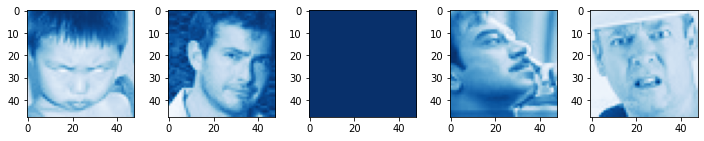

In [4]:
#angry class
plot_images(train_dir+'angry')

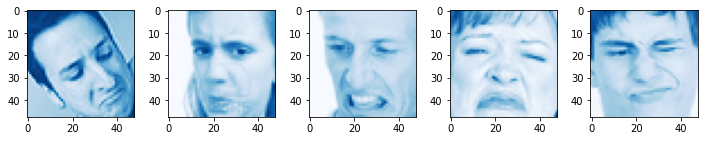

In [5]:
#disgust class
plot_images(train_dir+'/disgust')

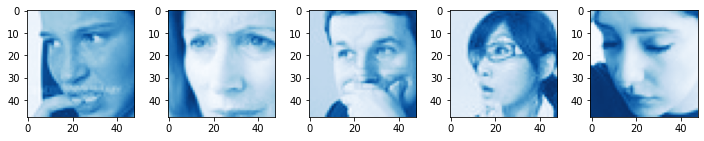

In [6]:
#fear class
plot_images(train_dir+'/fear')

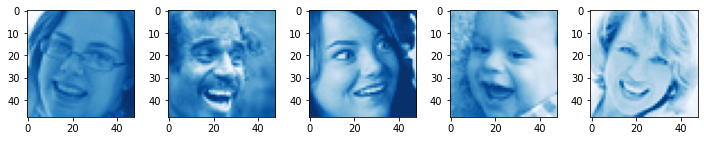

In [7]:
#happy class
plot_images(train_dir+'/happy')

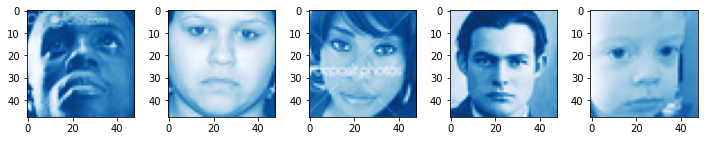

In [8]:
#neutral class
plot_images(train_dir+'/neutral')

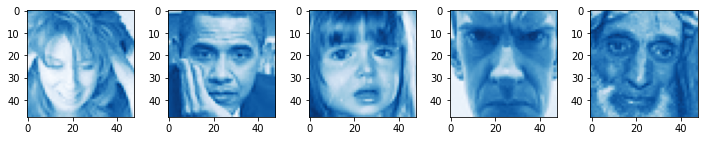

In [9]:
#sad class
plot_images(train_dir+'/sad')

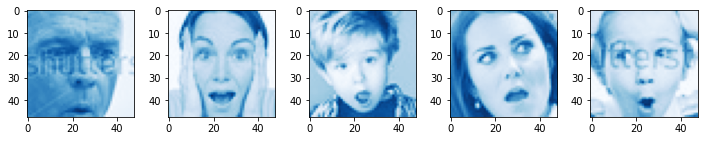

In [10]:
#surprise class
plot_images(train_dir+'/surprise')

In [11]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


The dataset consists of 2 folders - training and test All the images of dataset are grayscale images of size 48*48. Both these folders consist of 7 folders each.(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains approximately 36K images

Dataset is converted into raw images and splitted in multiple folders which are train and validation folders. 80% of our images are contained inside the train folder, and the last 20% are inside the validation folder.

##**Data Generators for ResNet**

In [12]:
img_size = 48
batch_size = 32

# selecting colour mode as rgb as resnet is trained on rgb photos and we have grascaled images
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
train_generator = datagen_train.flow_from_directory(train_dir,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
validation_generator = datagen_train.flow_from_directory(test_dir,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## **Building CNN model with ResNet**

In [13]:
#using pretrained model, RESNET50 architecture

tf.keras.applications.resnet50.ResNet50

<function keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, **kwargs)>

In [14]:
# creating a base model using resnet and loading the pretrained weights
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [15]:
# making all the layers except last 4 layers non trainable 
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [16]:
# Build model on the top of base model
model = tf.keras.Sequential()

model.add(base_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())

#Fully connected 1st layer
model.add(tf.keras.layers.Dense(512,kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.25))


# Fully connected layer 2nd layer
model.add(tf.keras.layers.Dense(256,kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.25))

#output layer
model.add(tf.keras.layers.Dense(7, activation='softmax'))

In [17]:
# Final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

In [18]:
# compiling the model

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
epochs=50
steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch

897

In [20]:
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps

224

In [21]:
# this decreases the learning rate if the model loss does not decrease 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001, mode='auto')
# to save model weights 
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_weights_resnet.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)
callbacks = [checkpoint, reduce_lr,early_stopping]

In [22]:
# Fitting the model 
history = model.fit(
    x=train_generator,
    batch_size=batch_size,
    epochs=epochs,
    validation_data = validation_generator,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.8598 - accuracy: 0.2728
Epoch 1: saving model to model_weights_resnet.h5
898/898 [==============================] - 792s 871ms/step - loss: 1.8598 - accuracy: 0.2728 - val_loss: 1.8854 - val_accuracy: 0.2328 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.7287 - accuracy: 0.3130
Epoch 2: saving model to model_weights_resnet.h5
898/898 [==============================] - 428s 476ms/step - loss: 1.7287 - accuracy: 0.3130 - val_loss: 1.7530 - val_accuracy: 0.3009 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.6904 - accuracy: 0.3265
Epoch 3: saving model to model_weights_resnet.h5
898/898 [==============================] - 368s 410ms/step - loss: 1.6904 - accuracy: 0.3265 - val_loss: 1.8552 - val_accuracy: 0.2370 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - ETA: 0s - loss: 1.6671 - accuracy: 0.3385
Epoch 4: saving model to 

## **Plotting Accuracy & Loss to analyze the results**

In [23]:
# saving the history of the model in data frame 
df=pd.DataFrame(model.history.history)

<AxesSubplot:>

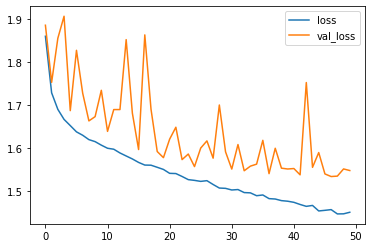

In [24]:
#Plotting Loss
df[['loss','val_loss']].plot()

<AxesSubplot:>

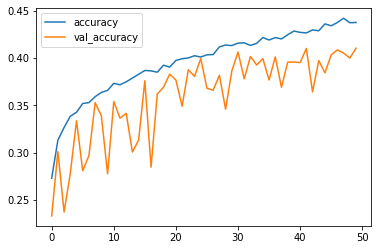

In [25]:
#Plotting accuracy
df[['accuracy','val_accuracy']].plot()

The model accuracy is very poor we wont use this model for our project

## **Data Generators for CNN**

In [26]:
img_size = 48
batch_size = 32

In [27]:
datagen_train =  tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
train_generator = datagen_train.flow_from_directory(train_dir,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  color_mode='grayscale',
                                                  class_mode='categorical')

datagen_validation =  tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,brightness_range=[0.8,1.2],rescale=1./255)
validation_generator = datagen_train.flow_from_directory(test_dir,
                                                  target_size=(img_size,img_size),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  color_mode='grayscale',
                                                  class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## **Building the custom CNN Model**

We chose to use a Convolutional Neural Network in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.

Now let's define the architecture of our CNN:

In [28]:
# Initialising the CNN
model = tf.keras.Sequential()

# 1 - Convolution
model.add(tf.keras.layers.Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# 2nd Convolution layer
model.add(tf.keras.layers.Conv2D(128,(5,5), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# 3rd Convolution layer
model.add(tf.keras.layers.Conv2D(512,(3,3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# 4th Convolution layer
model.add(tf.keras.layers.Conv2D(512,(3,3), padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Flattening
model.add(tf.keras.layers.Flatten())

# Fully connected layer 1st layer
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Fully connected layer 2nd layer
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.25))

# output layer 
model.add(tf.keras.layers.Dense(7, activation='softmax'))

# compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)      

We have used 4 conv layers and 2 fullyconnected layes each with relu activation as it is the fastesst, batch normalization to normalize the output for next layer and droupout function to reduce overfitting 

output layer contains 7 units for 7 diffrent emotions with softmax as activation

In [29]:
epochs=50
steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch

897

In [30]:
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps

224

In [31]:
#  adding various CAllBacks to prevent overfiiting
# this decreases the learning rate if the model loss does not decrease 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
# to save model weights 
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

In [32]:
# fitting the model
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
897/897 [==============================] - ETA: 0s - loss: 1.7359 - accuracy: 0.3331
Epoch 1: saving model to model_weights.h5
897/897 [==============================] - 1306s 1s/step - loss: 1.7359 - accuracy: 0.3331 - val_loss: 1.4253 - val_accuracy: 0.4519 - lr: 5.0000e-04
Epoch 2/50
897/897 [==============================] - ETA: 0s - loss: 1.3924 - accuracy: 0.4703
Epoch 2: saving model to model_weights.h5
897/897 [==============================] - 1472s 2s/step - loss: 1.3924 - accuracy: 0.4703 - val_loss: 1.2773 - val_accuracy: 0.5071 - lr: 5.0000e-04
Epoch 3/50
897/897 [==============================] - ETA: 0s - loss: 1.2732 - accuracy: 0.5125
Epoch 3: saving model to model_weights.h5
897/897 [==============================] - 1225s 1s/step - loss: 1.2732 - accuracy: 0.5125 - val_loss: 1.2794 - val_accuracy: 0.4943 - lr: 5.0000e-04
Epoch 4/50
897/897 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.5407
Epoch 4: saving model to model_weights.h

This model managed to obtain a accuracy of approximately 69% and val_accuracy of 64% on the dataset by running 50 epochs.which is quite good.

## **Plotting Accuracy & Loss to analyze the results**

In [33]:
# saving the history of the model in data frame 
df=pd.DataFrame(model.history.history)

Text(0, 0.5, 'loss')

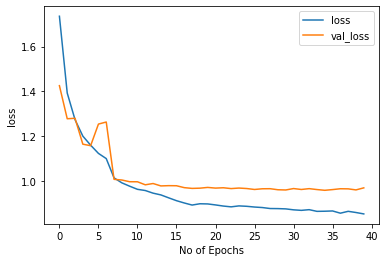

In [34]:
#Plotting Loss
df[['loss','val_loss']].plot()
plt.xlabel('No of Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'Accuracy')

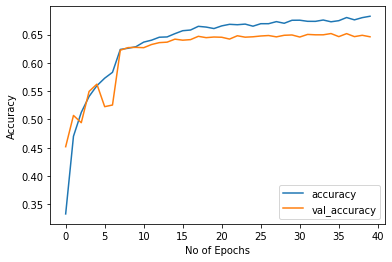

In [35]:
#Plotting Accuracy
df[['accuracy','val_accuracy']].plot()
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')

In [36]:
# saving the history in pickle file 
df.to_pickle("history_df.pkl")
# extracting the dataframe from pickle file 
history_df = pd.read_pickle("history_df.pkl")

In [37]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,1.735904,0.333124,1.425308,0.451869,0.0005
1,1.392416,0.470342,1.277292,0.507115,0.0005
2,1.273236,0.512501,1.279384,0.494280,0.0005
3,1.199685,0.540677,1.163528,0.549526,0.0005
4,1.159004,0.559647,1.156806,0.562360,0.0005


## **Saving Model**

In [38]:
model.save('models/Akash_CNN_model.h5')

In [39]:
FEM_model = keras.models.load_model('models/Akash_CNN_model.h5')

In [40]:
# Predicting For Test Set
predictions=FEM_model.predict(validation_generator)


In [41]:
from sklearn.metrics import plot_confusion_matrix
sklearn.metrics.confusion_matrix

<function sklearn.metrics._classification.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)>

In [42]:
# Printing Confution Matrix
cm=sklearn.metrics.confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=validation_generator.classes)
cm

array([[ 545,   10,   73,   53,  109,  141,   27],
       [  25,   55,    8,    5,    4,   10,    4],
       [ 109,    6,  342,   42,  119,  265,  141],
       [  36,    0,   24, 1524,   95,   55,   40],
       [  75,    2,   45,   86,  803,  202,   20],
       [ 124,    3,   98,   79,  219,  704,   20],
       [  21,    1,   47,   35,   28,   23,  676]], dtype=int64)

In [43]:
 # Accuracy Score of Our Model
acc=sklearn.metrics.accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=validation_generator.classes)
acc       


0.6476734466425188

C:\Users\AKASH\AppData\Local\Temp\ipykernel_15964\3436687449.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = FEM_model.predict_generator(generator=validation_generator)


<Figure size 432x288 with 0 Axes>

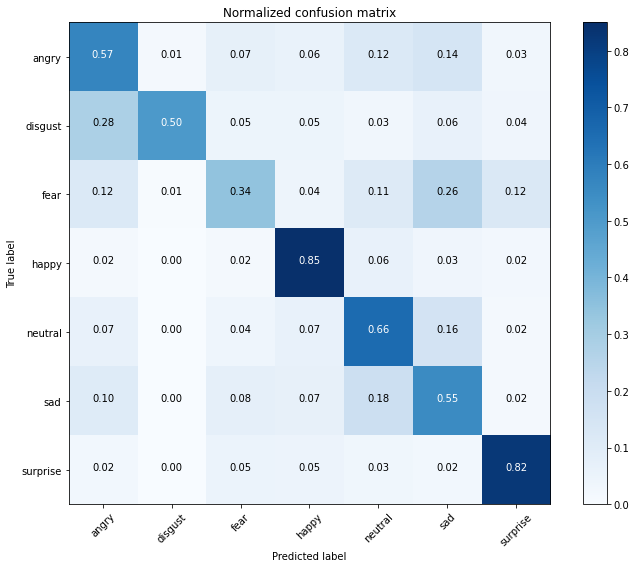

In [44]:
# show the confusion matrix of our predictions

# compute predictions
predictions = FEM_model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces maybe because it confuses them with sad faces.it also getting confused between angry and disgust face

# **Conclusion**

* Our model is giving an accuracy of 64 % and is also able to detect the emotions in low ligh 
* The application is able to detect face location and predict the right expression while checking it on a local webcam.
* The front-end of the model was made using streamlit for webapp and running well on local webapp link.
* Finally, we successfully deployed the Streamlit WebApp on Heroku and Streamlit share that runs on a web server.
* And I believe that through this model teachers can understand the students' perception during online classes and change the way of teaching if needed by understanding the students’ motive.
